# Bayesian Author Identification
#### By Carl Moser and Matthew Beaudouin-Lafon

Our goal for this project is to correctly identify the author of a text from a finite number of known authors.
To accomplish this, we process text from known authors and use this information to generate a likelihood function, which is used to perform a Bayesian update. In our first iteration, we simply applied word frequency analysis to the known texts. In the second iteration, we built Markov Chains for each author to capture sentence structure.

In [1]:
from thinkbayes2 import Suite
from pickle import load
from pickle import dump
import matplotlib.pyplot as plt
import thinkplot
import string
import sys
import re


def pickleDump(filename, todump):
    out = open('DATs/' + filename, 'wb+')
    for d in todump:
        dump(d, out)
    out.close()
    
def pickleLoad(fileName):
    f = open('DATs/' + fileName + '.dat', 'rb')
    testText = load(f)
    f.close()
    return testText
    
def getPickledMarkov(fileName):
    infile = open('DATs/' + fileName, 'rb+')
    chain = load(infile)
    wordCount = load(infile)
    author = load(infile)
    infile.close()
    return (chain, wordCount, author)

## Setting up the data

In this section, we process text files to generate Markov Chains and Word Frequency dictionaries. These data structures are then stored in files using Pickle. You can get the text (and DAT) files that we used [in our repository](https://github.com/MatthewBeaudouinLafon/BayesianAuthorIdentification).
We strip all punctuation and case sensitivity such that we only look at pairs of words. We made the decision to seperate and compute sentences seperately since we don't think that the last word of one sentence is related to the first word of the following sentence in the context of Markov Chains. This assumption may not be as accurate for text like poetry.
In the Markov Chain, the beginning of a sentence is denoted as '*'.

In [2]:
class MarkovChain():
    """
    Markov Chain class. 
    chain:       nested dictionary representing the number of occurences of a word given the previous word.
    wordCount:   dictionary of the number of total number of words (value) that have occured after the previous word (key).
    """
    
    def __init__(self, author):
        """
        Parameter: 
            - author: name of author (string)
        """
        self.author = author
        self.chain = {'*': {}}
        self.wordCount = {'*': 0}
    
    def addWord(self, prevWord, word):
        """
        Add a word to the Markov Chain.
        Takes the previous word and the current word as strings
        """
        self.chain[prevWord][word] = 1 + self.chain[prevWord].get(word, 0)
        self.wordCount[prevWord]= 1 + self.wordCount.get(prevWord, 0)
    
        # When encountering a new word, add it to the prefix dictionary
        if not self.chain.get(word):
            self.chain[word] = {}
        
    def addSentence(self, sentence):
        """
        Process a "sentence" to produce a Markov Chain. Takes a sentence as a list of lowercase words.
        NO ASTERISKS. SERIOUSLY.
        """
        # '*' represents the beginning of a sentence in the chain. 
        # This way, we can determine the probability of a word starting a sentence
        sentence = ['*'] + sentence
        if len(sentence) > 1:
            for i in [i + 1 for i in range(len(sentence)-1)]: # Start at the second word
                self.addWord(sentence[i-1], sentence[i])
        
    def getProb(self, prevWord, word):
        """
        Return the probability of getting word given prevWord.
        Takes two strings.
        """
        return self.chain[prevWord][word]/self.wordCount[prevWord]
    
def processGutenberg(fileName, author, make=True):
    """
    Process a Gutenberg text file.
    fileName: string
    author: string
    returns a markovChain object.
    """
    f = open('Texts/' + fileName + '.txt')
    
    #Skip to the beginning of the actual text
    for line in f:
        if line.startswith("*** START OF THIS PROJECT"):
            break
    
    text = ''
    
    # Put the text into one big string
    for line in f:
        # Stop when hitting the end of the book
        if line.startswith("*** END OF THIS PROJECT"):
            break
        
        text += line + ' '
        
    sentences = re.split('[.?!]', text) # Seperate text into a list of sentences sentence
    
    listOSentences = []
    for sentence in sentences:
        # Make all words lowercase and strip off punctuation
        sentenceList = ''.join(char for char in sentence if char in set(string.ascii_letters + string.digits + ' ')).lower().split()
        
        if sentenceList != []:
            listOSentences.append(sentenceList)
    
    f.close()
    
    if make==True:
        m = makeMarkov(listOSentences, author)
        pickleDump(fileName + '.dat', [m.chain, m.wordCount, m.author])
    else:
        pickleDump(fileName + '.dat', [listOSentences, author])

def makeMarkov(sentenceList, author):
    markovChain = MarkovChain(author)
    for sentence in sentenceList:
        # Process the sentence in the Markov Chain
        markovChain.addSentence(sentence)
    return markovChain

In [3]:
# Books are stored as text files in the format 'bookName.txt'
books = [('GreatExpectations', 'Charles Dickens'), ('Frankenstein', 'Mary Shelley'),
         ('RomeoAndJuliet', 'Shakespeare'), ('MobyDick', 'Herman Melville'), ('Twilight', 'Stephenie Meyer'),
         ("The Hitch Hiker's Guide to the Galaxy", 'Douglas Adams')]

unknown = ['whoWroteFrankenstein', 'whoWroteNewMoon', 'whoWroteWikipediaArticle']

In [4]:
# Generate DAT files for text from known authors
for book in books:
    name, author = book
    processGutenberg(name, author)
    
# Generate DAT files for other texts
for text in unknown:
    processGutenberg(text, 'Unknown', make=False)

## Word Frequency Based Identification


We decided to look at the word frequency of a text written by each of the authors that we chose. For the class, we made the author's name be the hypothesis and ddecided to store the word counts for the authors in a dicitonary. The word counts themselves are also dictionaries with the words as the key and the number of times that they appear in the text as the value. The Likelihood function takes in a word as the data and the author as the hypothesis. We use the author to find the word count within the class dictionary. From there, we return the number of times the word showed up in the author's text. Since not all of the words that we will be updating with will be in all of the different authors' word count, we decided to make a function within the class that checks if a word is in all of the authors' word count. With this information, we can decide whether or not to run Update with a given word in the sample text.

In [5]:
class FreqId(Suite):
    """
    Bayesian model for author identification. Uses Markov chains generated from texts who's authors are known as a likelihood function.
    Has a list of {author : MarkovChain objects}
    """
    def __init__(self):
        self.markovChains = {}
        self.totalWords = 0
        Suite.__init__(self)
    
    def isWorthChecking(self, word):
        worth = True
        for author, prob in self.Items():
            wordCount = self.markovChains[author][1]
            worth = worth and bool(wordCount.get(word))
        return worth
                
    def Likelihood(self, data, hypo):
        """
        data: word as string
        hypo: author as string
        """
        hypoAuthor = hypo
        chain, wordCount = self.markovChains[hypoAuthor]
        word = data
        #print('prob of ' + hypoAuthor +' = ', wordCount[word]/float(self.totalWords))
        return wordCount[word]/float(self.totalWords)
    
def runFreqIdentification(testText, freqId):
    # Reset the Suite
    author_probs = {}
    for author, prob in freqId.Items():
        author_probs[author] = [prob]
        freqId[author] = 1

    freqId.Normalize()
    
    # Run Updates
    for sentence in testText:
        sentence = ['*'] + sentence  # * represents the beginning of a sentence in the Markov Chain
        for word in sentence:
            if freqId.isWorthChecking(word):
                freqId.Update(word)
                for author, prob in freqId.Items():
                    author_probs[author].append(prob)
                    #if prob != 1:
                        #print(author, prob)
                
    for author in author_probs:
        x = range(0, len(author_probs[author]))
        plt.plot(x, author_probs[author], label=author)
        
    plt.suptitle('Frequency Identification')
    plt.xlabel('Update')
    plt.ylabel('Probability')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
    plt.show()
    plt.clf()
                
    # Print the authors and their likelihoods nicely
    for key, value in freqId.Items():
        print(key, value)
    print # Line return

## Markov Chain Based Identification

Similarly to what we did above, MarkovId inherits from thinbayes' Suite class to keep track of the Bayesian model. As such, it overloads the Likelihood method from Suite. The idea is to walk through the unknown text two words at a time. The goal of the likelihood function is to evaluate the probability that a certain author has written the text (based off their generated Markov Chain). It's important to note that this probability will be small even if the for the actual author of the text, but it will relatively be larger than the likelihood for the other authors. Bayesian inference allows us to normalize through.
We could get the likelihood by walking through the chain and multiplying the probabilities. However:
 * Since all probabilities are smaller than 1, is isn't unfathomable that we could hit the minimum float
 * We still have the same issue as previously of querying words that other authors haven't used  
 
The first issue is fairly minor; we could intelligently multiply by a constant factor that would get normalized for during the Bayesian update. For the second problem, we can't just pop off unwanted words from the sentence, otherwise we could make false connections. If we had a sequence 'a b c', and only 'a' and 'c' have been used by all authors, popping 'b' would make a Markov connection between 'a' and 'c'. So instead of just walking through and multiplying probabilities, we do individual updates on pairs of words, at the cost of computation time. When we encounter a word not seen before, we just skip that update. We do lose some information in the process since seeing a word that isn't in an author's vocabulary is strong evidence that they did not write the piece. We reconcile that by acknowledging that we can compensate with larger unknown text. The other solution would have been to assign to an unknown pair the probability of the least likely pair of words. We are less comfortable with it because instead of discarding information we are essentially fabricating. We cannot establish how much less likely it is for one author to be using a word over another if they have never used it.

So in practice, we have an 'isWorthChecking' method that checks the chain for both words in the Markov Chain before running the Update.

In [6]:
class MarkovId(Suite):
    """
    Bayesian model for author identification. Uses Markov chains generated from texts who's authors are known as a likelihood function.
    Has a list of {author : MarkovChain objects}
    """
    
    def __init__(self):
        self.markovChains = {}
        Suite.__init__(self)
                
    def Likelihood(self, data, hypo):
        """
        data: (string, string)
        hypo: (Markov Chain, Word Count dictionary, Author)
        """
        hypoAuthor = hypo
        chain, wordCount = self.markovChains[hypoAuthor]
        prevWord, word = data
        
        try:
            like = chain[prevWord][word]/float(wordCount[prevWord])
        except:
            print('isWorthChecking failed to check this pair of words')
            raise
            
        return like
    
    def isWorthChecking(self, prevWord, word):
        """
        Returns boolean based on whether a word is useful for bayesian update.
        A word is useful if it is found in the Markov Chain. 
        """
        worth = True
        for author, prob in self.Items():                   # Check every author
            chain = self.markovChains[author][0]
            worth = worth and (bool(chain.get(prevWord))        # Check the chain has prevWord
                          and bool(chain[prevWord].get(word)))  # And the sequence (prevWord, word)

        return worth
    
def runMarkovIdentification(testText, markovId):
    # Reset the Suite
    author_probs = {}
    for author, prob in markovId.Items():
        author_probs[author] = [prob]
        markovId[author] = 1

    markovId.Normalize()
    for sentence in testText:
        sentence = ['*'] + sentence # * represents the beginning of a sentence in the Markov Chain

        for i in range(len(sentence) - 1):          
            if markovId.isWorthChecking(sentence[i], sentence[i + 1]): # Check that the words are worth checking
                markovId.Update((sentence[i], sentence[i + 1]))        # Perform the Update
                for author, prob in markovId.Items():
                    author_probs[author].append(prob)
                
    for author in author_probs:
        x = range(0, len(author_probs[author]))
        plt.plot(x, author_probs[author], label=author)
        
    plt.suptitle('Markov Identification')
    plt.xlabel('Update')
    plt.ylabel('Probability')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=2)
    plt.show()
    plt.clf()
    
    # Print the authors and their likelihoods nicely
    for key, value in markovId.Items():
        print(key, value)
    print # Line return

## Results

In [7]:
files = ['Frankenstein.dat', 'GreatExpectations.dat', 'RomeoAndJuliet.dat', 'MobyDick.dat', "The Hitch Hiker's Guide to the Galaxy.dat", 'Twilight.dat']

markovId = MarkovId()
freqId = FreqId()

# Retrieve all pickled Markov Chains
for f in files:
    chain, wordCount, author = getPickledMarkov(f)
    freqId[author] = 1
    markovId[author] = 1
    freqId.markovChains[author] = (chain, wordCount)
    freqId.totalWords = sum(wordCount.values())
    markovId.markovChains[author] = (chain, wordCount)

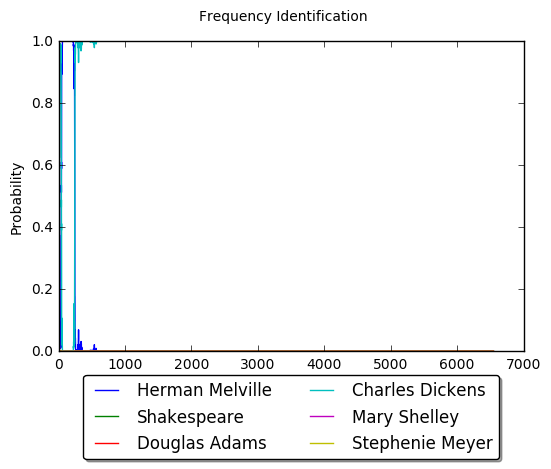

Herman Melville 0.0
Shakespeare 0.0
Douglas Adams 0.0
Stephenie Meyer 0.0
Mary Shelley 0.0
Charles Dickens 1.0


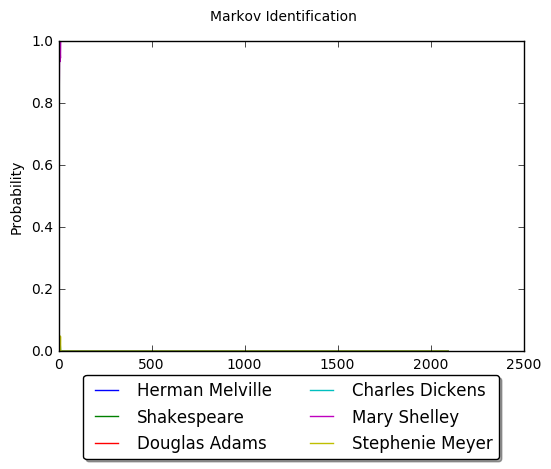

Herman Melville 0.0
Shakespeare 0.0
Douglas Adams 0.0
Stephenie Meyer 1.56905e-319
Mary Shelley 1.0
Charles Dickens 2.6692981827235488e-145


In [8]:
text = pickleLoad('whoWroteFrankenstein')
runFreqIdentification(text, freqId)
runMarkovIdentification(text, markovId)

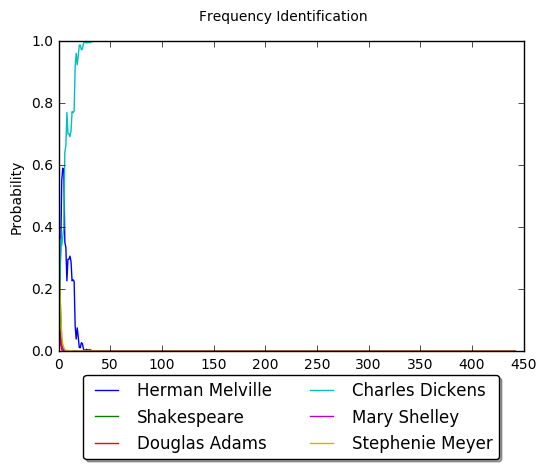

Herman Melville 7.485778266010094e-23
Shakespeare 1.731599388372228e-235
Douglas Adams 7.573817317266948e-299
Stephenie Meyer 3.9275152096806408e-56
Mary Shelley 1.854794842784361e-176
Charles Dickens 1.0


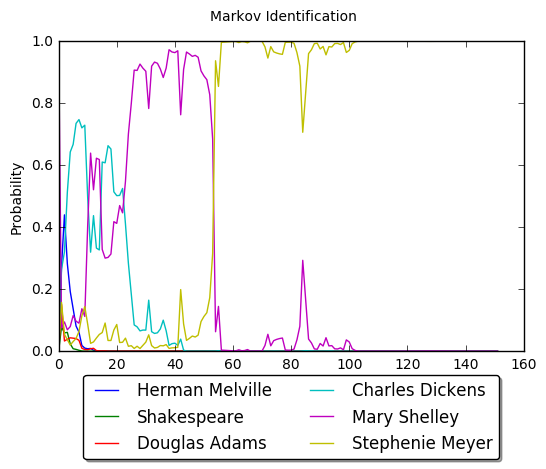

Herman Melville 8.478040293485966e-39
Shakespeare 1.0100489819447238e-48
Douglas Adams 6.137082419428952e-34
Stephenie Meyer 0.9999999019756007
Mary Shelley 9.767151839929643e-08
Charles Dickens 3.5288077157717317e-10


In [9]:
text = pickleLoad('whoWroteNewMoon')
runFreqIdentification(text, freqId)
runMarkovIdentification(text, markovId)

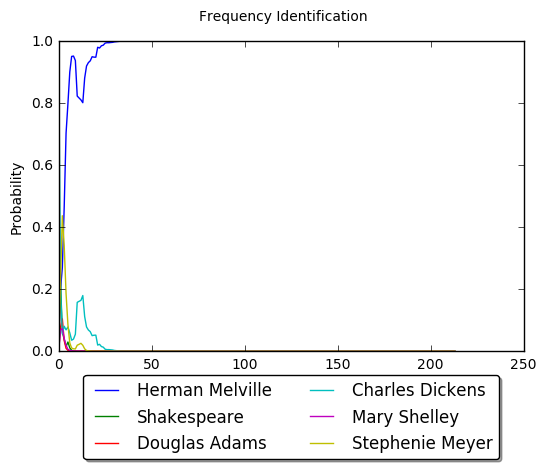

Herman Melville 1.0
Shakespeare 5.873545584972421e-99
Douglas Adams 8.000953505569417e-147
Stephenie Meyer 1.2209152294741537e-85
Mary Shelley 6.770208396658985e-104
Charles Dickens 8.245688734383712e-29


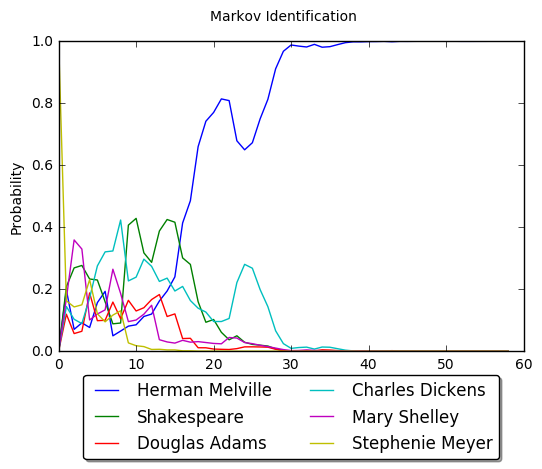

Herman Melville 0.9996765908176865
Shakespeare 2.4035433963331073e-07
Douglas Adams 0.00031464903541387996
Stephenie Meyer 1.2014853795363378e-11
Mary Shelley 6.001033900746327e-06
Charles Dickens 2.5187466443188278e-06


In [10]:
text = pickleLoad('whoWroteWikipediaArticle')
runFreqIdentification(text, freqId)
runMarkovIdentification(text, markovId)